<a href="https://colab.research.google.com/github/SelenArikan/Plant/blob/main/Plant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import os
import time
import copy
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import os

os.environ['KAGGLE_USERNAME'] = "YOUR_KAGGLE_USERNAME_HERE"
os.environ['KAGGLE_KEY'] = "d79ba611e44d21ed31b67d65d3781bf2"

!kaggle datasets download -d emmarex/plantdisease
!unzip -q plantdisease.zip -d plant_disease_data

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
y
 76% 497M/658M [00:00<00:00, 1.74GB/s]
100% 658M/658M [00:00<00:00, 1.69GB/s]


In [ ]:

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


if os.path.exists('./plant_disease_data/PlantVillage'):
    data_dir = './plant_disease_data/PlantVillage'
elif os.path.exists('./plant_disease_data/plantvillage'):
    data_dir = './plant_disease_data/plantvillage'
else:

    data_dir = './plant_disease_data'

print(f"Loading data from: {data_dir}")

try:
    full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)


    if len(full_dataset.classes) <= 1:
        print("\n CRITICAL ERROR: Still only found 1 class. Checking deeper...")
        possible_path = os.path.join(data_dir, 'PlantVillage')
        if os.path.exists(possible_path):
            data_dir = possible_path
            full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)
            print(f"Fixed! Found data at: {data_dir}")

    print(f"Classes found: {len(full_dataset.classes)}")
    print(f"Example classes: {full_dataset.classes[:5]}")

    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")

except Exception as e:
    print(f"Error: {e}")

Loading data from: ./plant_disease_data/PlantVillage
Classes found: 15
Example classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
Train size: 16510, Test size: 4128


In [ ]:

def get_teacher_model(num_classes):
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model.to(device)
class StudentCNN(nn.Module):
    def __init__(self, num_classes):
        super(StudentCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
if 'full_dataset' in globals():
    num_classes = len(full_dataset.classes)
    teacher = get_teacher_model(num_classes)
    student = StudentCNN(num_classes).to(device)
    print("Teacher unlocked for full training!")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 69.9MB/s]


Teacher unlocked for full training!


In [ ]:
class DistillationLoss(nn.Module):
    def __init__(self, temperature=3.0, alpha=0.7):
        super(DistillationLoss, self).__init__()
        self.T = temperature
        self.alpha = alpha
        self.kl_div = nn.KLDivLoss(reduction='batchmean')
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, student_logits, teacher_logits, labels):
        soft_student = F.log_softmax(student_logits / self.T, dim=1)
        soft_teacher = F.softmax(teacher_logits / self.T, dim=1)
        loss_kd = self.kl_div(soft_student, soft_teacher) * (self.T ** 2)
        loss_ce = self.ce_loss(student_logits, labels)
        total_loss = (self.alpha * loss_kd) + ((1 - self.alpha) * loss_ce)
        return total_loss

In [ ]:
def train_model(model, loader, optimizer, criterion, device, teacher_model=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    if teacher_model:
        teacher_model.eval()

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        if teacher_model:
            with torch.no_grad():
                teacher_outputs = teacher_model(images)
            loss = criterion(outputs, teacher_outputs, labels)
        else:
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100. * correct / total

def evaluate_model(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100. * correct / total

In [ ]:


print("--- Training Teacher (ResNet18 - Full Fine Tuning) ---")


optimizer_teacher = optim.Adam(teacher.parameters(), lr=1e-4)
criterion_ce = nn.CrossEntropyLoss()
epochs_teacher = 40

for epoch in range(epochs_teacher):
    loss, acc = train_model(teacher, train_loader, optimizer_teacher, criterion_ce, device)
    val_acc = evaluate_model(teacher, test_loader, device)
    print(f"Teacher Epoch {epoch+1}/{epochs_teacher} | Loss: {loss:.4f} | Train Acc: {acc:.2f}% | Val Acc: {val_acc:.2f}%")

print(f"Teacher Training Complete. Final Accuracy: {val_acc:.2f}%")

--- Training Teacher (ResNet18 - Full Fine Tuning) ---
Teacher Epoch 1/40 | Loss: 0.2513 | Train Acc: 93.21% | Val Acc: 97.82%
Teacher Epoch 2/40 | Loss: 0.0579 | Train Acc: 98.29% | Val Acc: 98.57%
Teacher Epoch 3/40 | Loss: 0.0391 | Train Acc: 98.85% | Val Acc: 99.35%
Teacher Epoch 4/40 | Loss: 0.0225 | Train Acc: 99.34% | Val Acc: 98.55%
Teacher Epoch 5/40 | Loss: 0.0266 | Train Acc: 99.15% | Val Acc: 98.26%
Teacher Epoch 6/40 | Loss: 0.0225 | Train Acc: 99.37% | Val Acc: 99.32%
Teacher Epoch 7/40 | Loss: 0.0176 | Train Acc: 99.52% | Val Acc: 99.22%
Teacher Epoch 8/40 | Loss: 0.0254 | Train Acc: 99.19% | Val Acc: 99.27%
Teacher Epoch 9/40 | Loss: 0.0177 | Train Acc: 99.45% | Val Acc: 99.49%
Teacher Epoch 10/40 | Loss: 0.0140 | Train Acc: 99.56% | Val Acc: 99.10%
Teacher Epoch 11/40 | Loss: 0.0124 | Train Acc: 99.58% | Val Acc: 99.64%
Teacher Epoch 12/40 | Loss: 0.0143 | Train Acc: 99.57% | Val Acc: 99.32%
Teacher Epoch 13/40 | Loss: 0.0116 | Train Acc: 99.67% | Val Acc: 98.59%
Teach

In [ ]:
student_scratch = StudentCNN(num_classes).to(device)
optimizer_scratch = optim.Adam(student_scratch.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_scratch, step_size=7, gamma=0.1)

criterion_ce = nn.CrossEntropyLoss()
history_scratch = []
epochs = 40

for epoch in range(epochs):
    loss, acc = train_model(student_scratch, train_loader, optimizer_scratch, criterion_ce, device)
    val_acc = evaluate_model(student_scratch, test_loader, device)
    history_scratch.append(val_acc)

    print(f"Student(No KD) Epoch {epoch+1}/{epochs} | Loss: {loss:.4f} | Train Acc: {acc:.2f}% | Val Acc: {val_acc:.2f}%")


    scheduler.step()

Student(No KD) Epoch 1/40 | Loss: 1.3921 | Train Acc: 54.45% | Val Acc: 77.08%
Student(No KD) Epoch 2/40 | Loss: 0.8638 | Train Acc: 70.96% | Val Acc: 81.13%
Student(No KD) Epoch 3/40 | Loss: 0.7058 | Train Acc: 76.34% | Val Acc: 86.07%
Student(No KD) Epoch 4/40 | Loss: 0.5971 | Train Acc: 79.95% | Val Acc: 89.68%
Student(No KD) Epoch 5/40 | Loss: 0.5256 | Train Acc: 82.43% | Val Acc: 90.14%
Student(No KD) Epoch 6/40 | Loss: 0.4606 | Train Acc: 84.78% | Val Acc: 91.42%
Student(No KD) Epoch 7/40 | Loss: 0.4245 | Train Acc: 85.84% | Val Acc: 91.62%
Student(No KD) Epoch 8/40 | Loss: 0.2946 | Train Acc: 90.07% | Val Acc: 94.43%
Student(No KD) Epoch 9/40 | Loss: 0.2696 | Train Acc: 90.76% | Val Acc: 94.74%
Student(No KD) Epoch 10/40 | Loss: 0.2467 | Train Acc: 91.57% | Val Acc: 94.96%
Student(No KD) Epoch 11/40 | Loss: 0.2358 | Train Acc: 91.84% | Val Acc: 95.28%
Student(No KD) Epoch 12/40 | Loss: 0.2335 | Train Acc: 91.90% | Val Acc: 95.52%
Student(No KD) Epoch 13/40 | Loss: 0.2324 | Train

In [ ]:
student_kd = StudentCNN(num_classes).to(device)
optimizer_kd = optim.Adam(student_kd.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_kd, step_size=7, gamma=0.1)
kd_criterion = DistillationLoss(temperature=4.0, alpha=0.7)
history_kd = []
epochs = 40

for epoch in range(epochs):
    loss, acc = train_model(student_kd, train_loader, optimizer_kd, kd_criterion, device, teacher_model=teacher)
    val_acc = evaluate_model(student_kd, test_loader, device)
    history_kd.append(val_acc)
    print(f"Student(KD) Epoch {epoch+1}/{epochs} | Loss: {loss:.4f} | Train Acc: {acc:.2f}% | Val Acc: {val_acc:.2f}%")


Student(KD) Epoch 1/40 | Loss: 11.7612 | Train Acc: 56.03% | Val Acc: 73.72%
Student(KD) Epoch 2/40 | Loss: 7.3935 | Train Acc: 73.65% | Val Acc: 82.58%
Student(KD) Epoch 3/40 | Loss: 6.2403 | Train Acc: 78.67% | Val Acc: 87.02%
Student(KD) Epoch 4/40 | Loss: 5.5093 | Train Acc: 82.37% | Val Acc: 88.74%
Student(KD) Epoch 5/40 | Loss: 5.0720 | Train Acc: 84.30% | Val Acc: 91.81%
Student(KD) Epoch 6/40 | Loss: 4.5685 | Train Acc: 86.71% | Val Acc: 92.15%
Student(KD) Epoch 7/40 | Loss: 4.2870 | Train Acc: 88.06% | Val Acc: 93.34%
Student(KD) Epoch 8/40 | Loss: 3.9534 | Train Acc: 89.50% | Val Acc: 93.90%
Student(KD) Epoch 9/40 | Loss: 3.7807 | Train Acc: 90.31% | Val Acc: 94.09%
Student(KD) Epoch 10/40 | Loss: 3.6700 | Train Acc: 90.88% | Val Acc: 93.87%
Student(KD) Epoch 11/40 | Loss: 3.5273 | Train Acc: 91.68% | Val Acc: 94.65%
Student(KD) Epoch 12/40 | Loss: 3.3986 | Train Acc: 92.14% | Val Acc: 94.23%
Student(KD) Epoch 13/40 | Loss: 3.2835 | Train Acc: 92.68% | Val Acc: 95.20%
Student

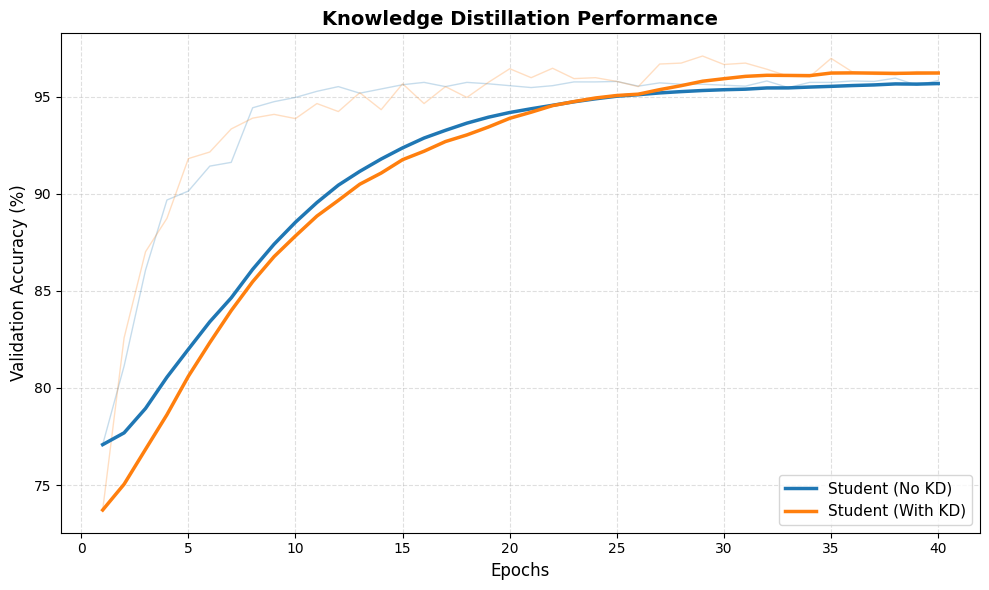

Model                     | Max Accuracy | Final Accuracy
------------------------------------------------------------
Teacher (ResNet)          | 99.32%      | -
Student (No KD)           | 95.95%      | 95.83%
Student (With KD)         | 97.09%      | 96.25%


In [ ]:

import matplotlib.pyplot as plt
import numpy as np

def smooth_curve(points, factor=0.85):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
epochs_range = range(1, len(history_scratch) + 1)
smooth_scratch = smooth_curve(history_scratch, factor=0.85)
smooth_kd = smooth_curve(history_kd, factor=0.85)
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(epochs_range, history_scratch, color='tab:blue', alpha=0.25, linewidth=1)
plt.plot(epochs_range, history_kd, color='tab:orange', alpha=0.25, linewidth=1)
plt.plot(epochs_range, smooth_scratch, label='Student (No KD)', color='tab:blue', linewidth=2.5)
plt.plot(epochs_range, smooth_kd, label='Student (With KD)', color='tab:orange', linewidth=2.5)
plt.title('Knowledge Distillation Performance', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Validation Accuracy (%)', fontsize=12)
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, alpha=0.4, linestyle='--')
plt.xticks(np.arange(0, len(history_scratch)+1, 5))

plt.tight_layout()
plt.show()
print(f"{'Model':<25} | {'Max Accuracy':<10} | {'Final Accuracy':<10}")
print("-" * 60)
print(f"{'Teacher (ResNet)':<25} | {evaluate_model(teacher, test_loader, device):.2f}%      | -")
print(f"{'Student (No KD)':<25} | {max(history_scratch):.2f}%      | {history_scratch[-1]:.2f}%")
print(f"{'Student (With KD)':<25} | {max(history_kd):.2f}%      | {history_kd[-1]:.2f}%")

In [ ]:

print("Number of classes found:", len(full_dataset.classes))
print("Class names:", full_dataset.classes)
import os
print("\nFiles in data folder:")
print(os.listdir('./plant_disease_data'))


Number of classes found: 15
Class names: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']

Files in data folder:
['PlantVillage', 'plantvillage']


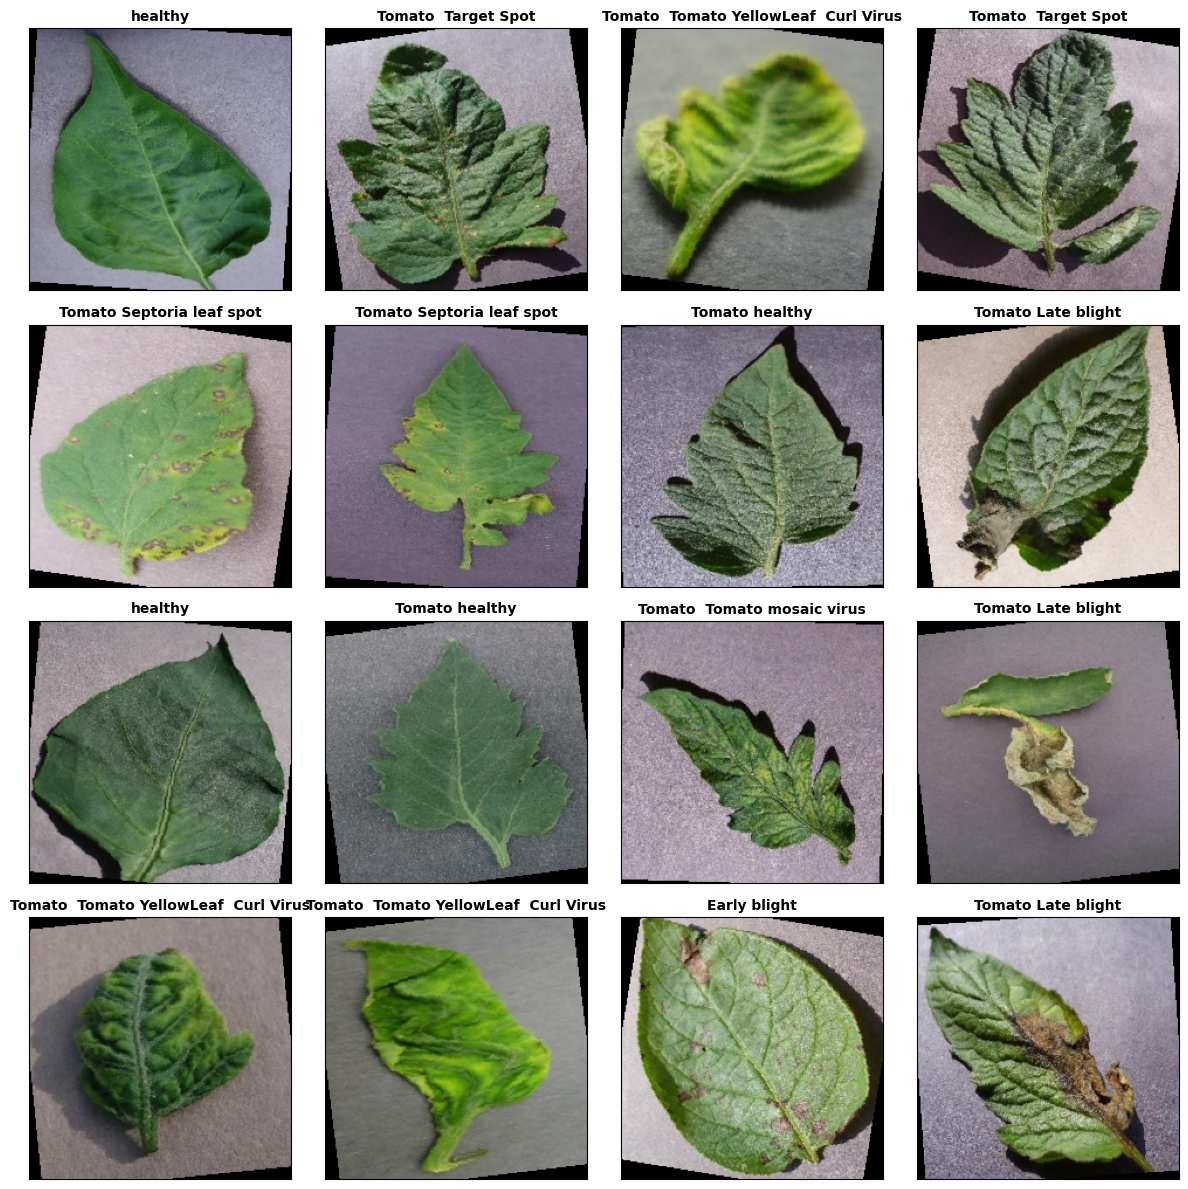

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow_grid(inp, title=None):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

images, labels = next(iter(train_loader))
num_images = 16
images = images[:num_images]
labels = labels[:num_images]

fig = plt.figure(figsize=(12, 12))

for idx in range(num_images):
    ax = fig.add_subplot(4, 4, idx + 1, xticks=[], yticks=[])
    img = imshow_grid(images[idx])
    plt.imshow(img)

    class_name = full_dataset.classes[labels[idx]]
    clean_name = class_name.split('___')[-1].replace('_', ' ')

    ax.set_title(clean_name, fontsize=10, color='black', weight='bold')

plt.tight_layout()
plt.savefig('dataset_samples.png', dpi=300, bbox_inches='tight')
plt.show()

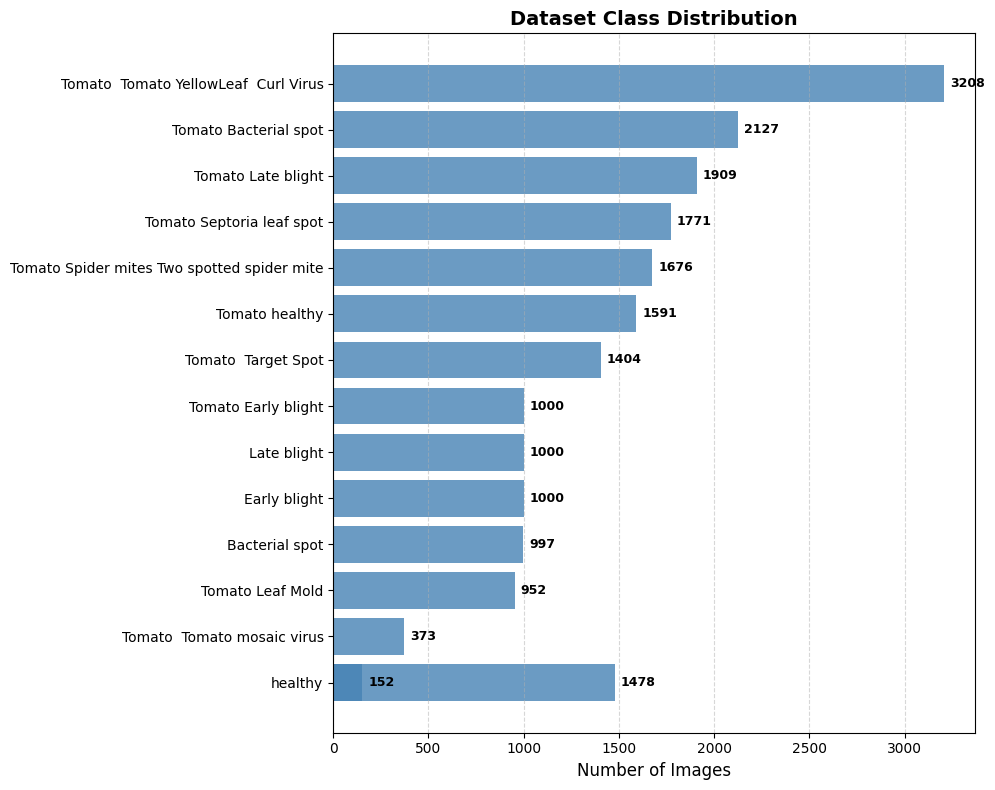

In [ ]:
import matplotlib.pyplot as plt
import collections
import numpy as np

all_targets = full_dataset.targets
counts = collections.Counter(all_targets)

class_names = []
class_counts = []

for idx in range(len(full_dataset.classes)):
    count = counts[idx]
    if count > 0:
        class_counts.append(count)
        raw_name = full_dataset.classes[idx]
        clean_name = raw_name.split('___')[-1].replace('_', ' ')
        class_names.append(clean_name)

sorted_pairs = sorted(zip(class_counts, class_names), reverse=False)
sorted_counts, sorted_names = zip(*sorted_pairs)

plt.figure(figsize=(10, len(sorted_names) * 0.4 + 2))

bars = plt.barh(sorted_names, sorted_counts, color='steelblue', alpha=0.8)

for bar in bars:
    width = bar.get_width()
    plt.text(width + (max(sorted_counts)*0.01),
             bar.get_y() + bar.get_height()/2,
             f'{int(width)}',
             va='center', fontsize=9, fontweight='bold', color='black')

plt.title('Dataset Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Number of Images', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

Generating Confusion Matrix...
Saved 'confusion_matrix.png'.


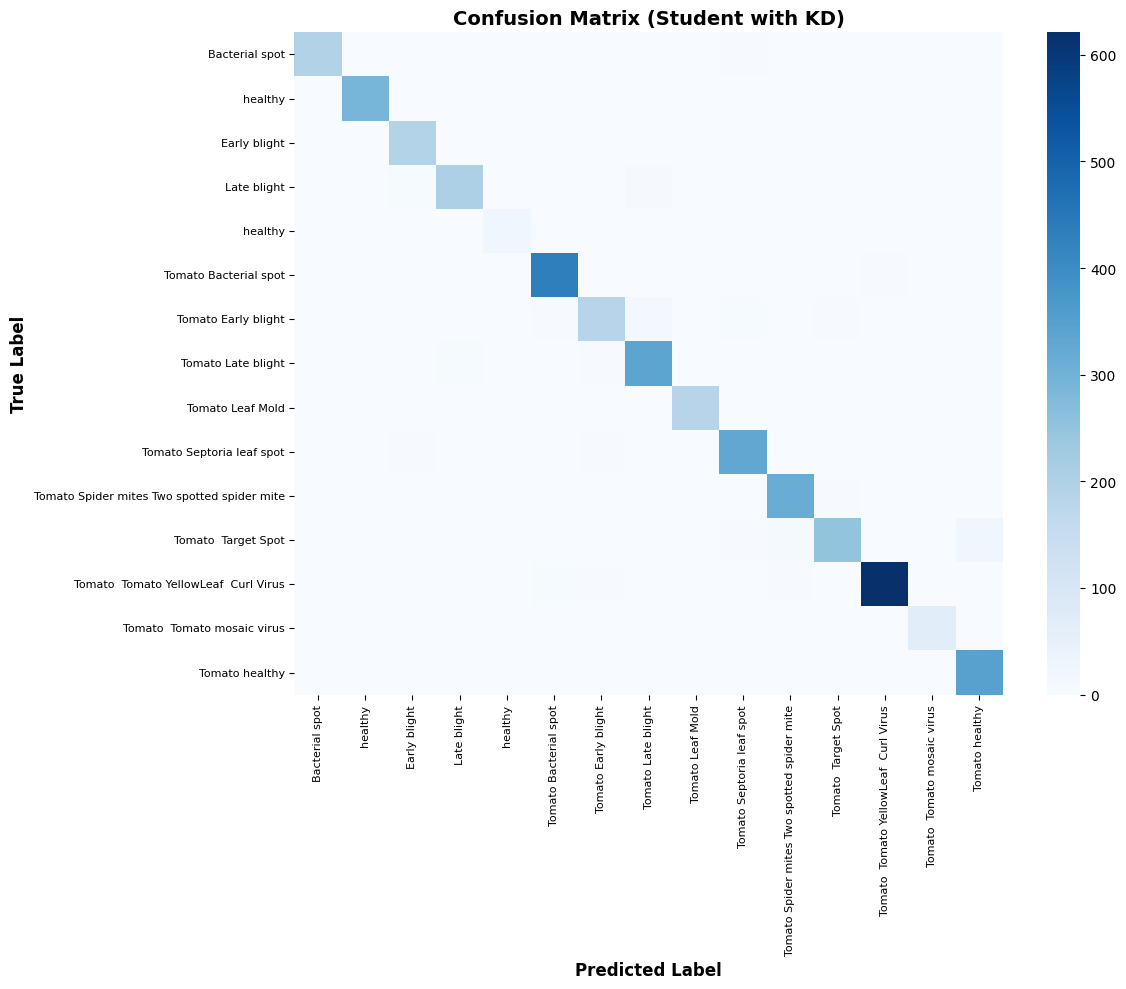

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
import matplotlib.pyplot as plt

model_to_test = student_kd
model_to_test.eval()

y_true = []
y_pred = []

print("Generating Confusion Matrix...")

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_to_test(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cleaned_class_names = [name.split('___')[-1].replace('_', ' ') for name in full_dataset.classes]

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=cleaned_class_names,
            yticklabels=cleaned_class_names)

plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix (Student with KD)', fontsize=14, fontweight='bold')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("Saved 'confusion_matrix.png'.")
plt.show()

Saved 'model_size_comparison.png'.


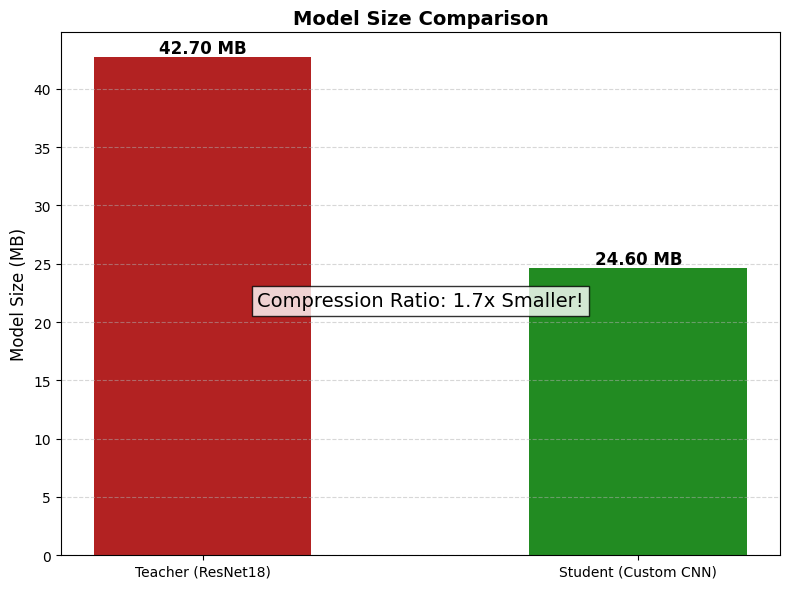

In [ ]:
import matplotlib.pyplot as plt

def get_model_size_mb(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

teacher_size = get_model_size_mb(teacher)
student_size = get_model_size_mb(student_kd)

models = ['Teacher (ResNet18)', 'Student (Custom CNN)']
sizes = [teacher_size, student_size]
colors = ['firebrick', 'forestgreen']

plt.figure(figsize=(8, 6))
bars = plt.bar(models, sizes, color=colors, width=0.5)

plt.ylabel('Model Size (MB)', fontsize=12)
plt.title('Model Size Comparison', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f} MB',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

compression_ratio = teacher_size / student_size
plt.text(0.5, max(sizes)*0.5,
         f'Compression Ratio: {compression_ratio:.1f}x Smaller!',
         ha='center', fontsize=14, color='black', bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('model_size_comparison.png', dpi=300)
print("Saved 'model_size_comparison.png'.")
plt.show()

In [ ]:

try:
    import torchviz
except ImportError:
    !pip install torchviz
    import torchviz

from torchviz import make_dot
import torch

x = torch.randn(1, 3, 224, 224).to(device)
y = student_kd(x)

dot = make_dot(y, params=dict(student_kd.named_parameters()))
dot.format = 'png'
dot.render("student_architecture")

print("Architecture diagram saved as 'student_architecture.png'.")

Architecture diagram saved as 'student_architecture.png'.
